## Timoshenko Eqution :
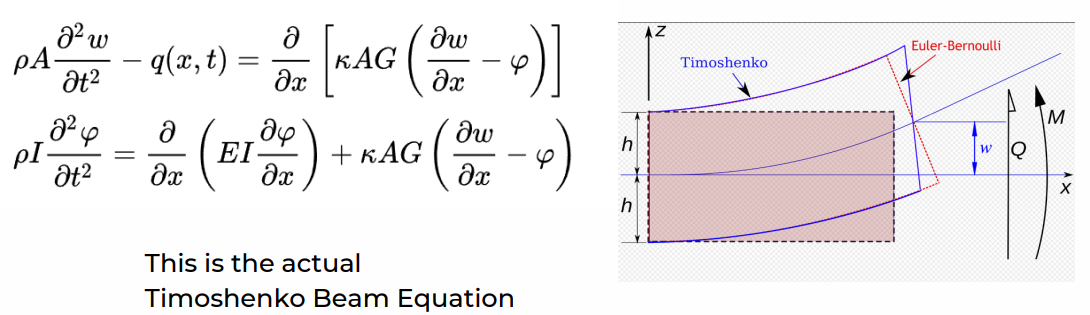






### Problem 1 :
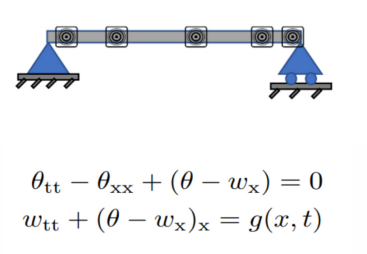

In [1]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import numpy as np
from deepxde.backend import tf

# Define the geometry and time domain
geom = dde.geometry.Interval(0, np.pi)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Define the PDE system
def pde(x, u):
    o = u[:, 0:1]    # Rotation theta
    w = u[:, 1:2]    # Displacement w
    ###
    do_x = dde.grad.jacobian(u, x, i=0, j=0) # do/dx
    do_t = dde.grad.jacobian(u, x, i=0, j=1) # do/dt
    do_xx = dde.grad.hessian(u, x, component=0, i=0, j=0) #d2o/dx2
    do_tt = dde.grad.hessian(u, x, component=0, i=1, j=1) #d2o/dt2
    ###
    dw_x = dde.grad.jacobian(u, x, i=1, j=0) # dw/dx
    dw_t = dde.grad.jacobian(u, x, i=1, j=1) # dw/dt
    dw_xx = dde.grad.hessian(u, x, component=1, i=0, j=0) #d2w/dx2
    dw_tt = dde.grad.hessian(u, x, component=1, i=1, j=1) #d2w/dt2

    # Calculate the external force
    g = 0

    # Define the PDEs
    eq1 = (do_tt - do_xx + o - dw_x)
    eq2 = (dw_tt + do_x - dw_xx - g)

    return [eq1, eq2]


# θ(x,t) = 2/π * Σ[n=1 to infinity] (sinh(nπx) / sinh(nπ)) * cos(nπt)

# w(x,t) = 4/π * Σ[n=1 to infinity] (sinh(nπx) / sinh(nπ)) * cos(nπt) / n


def func_o(x):
    return (tf.sin(x[:, 0:1])/tf.cos(x[:, 1:2]))


def func_w(x):
    return tf.sin(x[:, 0:1])/tf.cos(x[:, 1:2])


def boundary(_, on_initial):
    return on_initial


# def initial_o(x, y):
#     do_t = dde.grad.jacobian(y, x, i=0, j=1)
#     g = 0
#     return ( do_t - g )

# def initial_w(x, y):
#     dw_t = dde.grad.jacobian(y, x, i=1, j=1)
#     g = 0
#     return ( dw_t - g )


bc1 = dde.icbc.DirichletBC(geomtime, func_o, lambda _, on_boundary: on_boundary, component=0) #o(0,t)=o(pi,t)=0
bc2 = dde.icbc.DirichletBC(geomtime, func_w, lambda _, on_boundary: on_boundary, component=1) #w(0,t)=w(pi,t)=0
ic1 = dde.icbc.IC(geomtime, lambda x: tf.cos(x[:, 0:1]) , boundary, component=0) #o(x,0)= cos(x)
ic2 = dde.icbc.IC(geomtime, lambda x: tf.sin(x[:, 0:1]), boundary, component=1) #w(x,0)= sin(x)
ic3 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: dde.grad.jacobian(y, x, i=0, j=1), lambda _, on_initial: on_initial) #do(x,0)/dt = 0
ic4 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: dde.grad.jacobian(y, x, i=1, j=1), lambda _, on_initial: on_initial) #dw(x,0)/dt = 0
# ic3 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: initial_o(x, y), lambda x, _: np.isclose(x[1], 0)) #do(x,0)/dt = 0
# ic4 = dde.icbc.OperatorBC(geomtime, lambda x, y, _: initial_w(x, y), lambda x, _: np.isclose(x[1], 0)) #dw(x,0)/dt = 0


data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc1, bc2, ic1, ic2, ic3, ic4],
    num_domain=8000,  # number of training points sampled inside the domain
    num_boundary=3000,# number of training points sampled on the boundary
    num_initial=3000, # number of training points sampled on the initial location
)

net = dde.nn.FNN([2] + 4 * [50] + [3], "tanh", "Glorot normal")

model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=4000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


Instructions for updating:
non-resource variables are not supported in the long term

Compiling model...
Building feed-forward neural network...
'build' took 0.053513 s



C:\Users\ankit\anaconda3\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:114: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.926981 s

Initializing variables...
Training model...

Step      Train loss                                                                          Test loss                                                                           Test metric
0         [1.41e-01, 3.54e-02, 1.07e-01, 1.81e-01, 4.22e-01, 1.74e-01, 1.40e-01, 6.71e-03]    [1.41e-01, 3.54e-02, 1.07e-01, 1.81e-01, 4.22e-01, 1.74e-01, 1.40e-01, 6.71e-03]    []  
1000      [1.08e-03, 1.45e-03, 4.27e-03, 5.77e-06, 4.73e-02, 4.30e-04, 2.04e-03, 1.91e-04]    [1.08e-03, 1.45e-03, 4.27e-03, 5.77e-06, 4.73e-02, 4.30e-04, 2.04e-03, 1.91e-04]    []  
2000      [3.61e-03, 7.92e-04, 1.12e-03, 1.79e-05, 3.30e-02, 8.63e-05, 6.43e-04, 1.14e-04]    [3.61e-03, 7.92e-04, 1.12e-03, 1.79e-05, 3.30e-02, 8.63e-05, 6.43e-04, 1.14e-04]    []  
3000      [5.28e-04, 3.12e-04, 1.12e-03, 5.21e-07, 2.64e-02, 2.70e-05, 6.00e-04, 5.19e-05]    [5.28e-04, 3.12e-04, 1.12e-03, 5.21e-07, 2.64e-02, 2.70e-05, 6.00e-04, 5.19e-05]    []  
4000  

Saving loss history to C:\Users\ankit\loss.dat ...
Saving training data to C:\Users\ankit\train.dat ...
Saving test data to C:\Users\ankit\test.dat ...


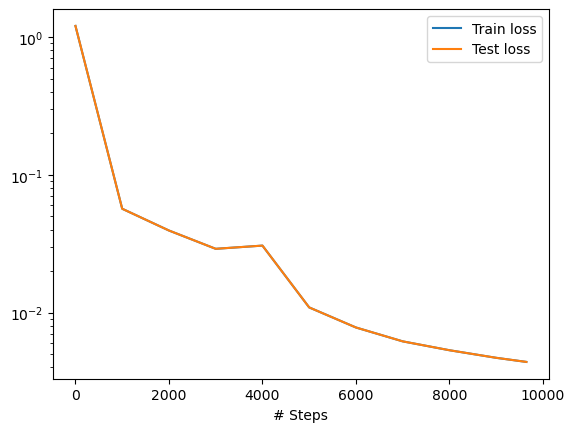

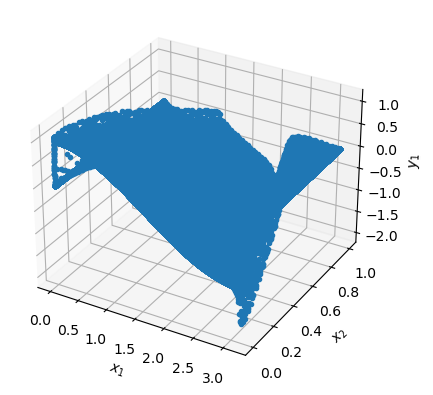

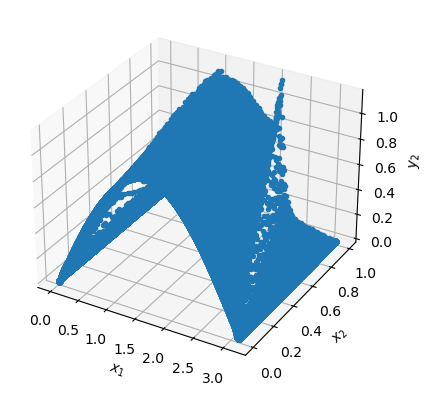

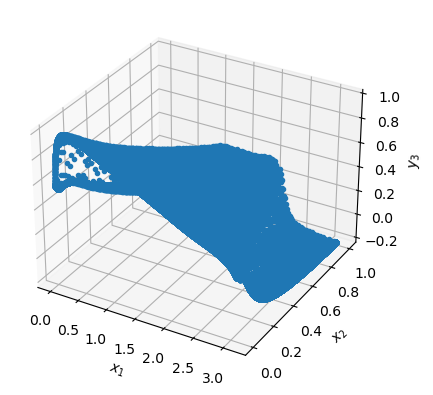

In [2]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [40]:
import numpy as np
import tensorflow as tf

xx = np.linspace(0, np.pi, 100)
tt = np.linspace(0, 1, 5)

arr = []
for i in range(5):
    for j in range(100):
        arr.append([xx[j], tt[i]])

arr = np.array(arr)

output = model.predict(arr)
o_pred = output[:, 0]
w_pred = output[:, 1]

def func_o(x):
    return ( (tf.sin(x[:, 0:1])/tf.cos(x[:, 1:2])))

def func_w(x):
    return tf.sin(x[:, 0:1])/tf.cos(x[:, 1:2])

o_exact = tf.reshape(func_o(arr), [-1])
w_exact = tf.reshape(func_w(arr), [-1])

In [41]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# your existing code here

with tf.compat.v1.Session() as sess:
    o_exact_arr = sess.run(o_exact)
    w_exact_arr = sess.run(w_exact)

import pandas as pd
df_x_t = pd.DataFrame(arr)
df_o_pred = pd.DataFrame(o_pred)
df_o_exact = pd.DataFrame(o_exact_arr)
df_w_pred = pd.DataFrame(w_pred)
df_w_exact = pd.DataFrame(w_exact_arr)


C:\Users\ankit\AppData\Local\Temp\ipykernel_24616\3091831110.py:41: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


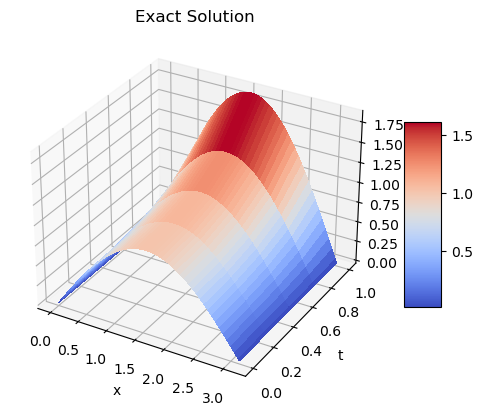

In [59]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

xx = np.linspace(0, np.pi, 100)
tt = np.linspace(0, 1, 5)

arr = []
for i in range(5):
    for j in range(100):
        arr.append([xx[j], tt[i]])

arr = np.array(arr)

output = model.predict(arr)
o_pred = output[:, 0]
w_pred = output[:, 1]

def func_o(x):
    return ( (tf.sin(x[:, 0:1])/tf.cos(x[:, 1:2])))

def func_w(x):
    return tf.sin(x[:, 0:1])/tf.cos(x[:, 1:2])

o_exact = tf.reshape(func_o(arr), [-1])
w_exact = tf.reshape(func_w(arr), [-1])

with tf.Session() as sess:
    o_exact_val = sess.run(o_exact)

# Create meshgrid
X, T = np.meshgrid(xx, tt)
O_exact = np.reshape(o_exact_val, X.shape)

# Plot surface
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, T, O_exact, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize axes
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('o')
ax.set_title('Exact Solution')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


C:\Users\ankit\AppData\Local\Temp\ipykernel_24616\2929453463.py:44: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


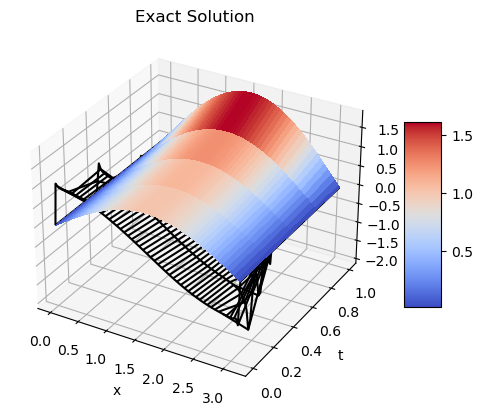

In [60]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

xx = np.linspace(0, np.pi, 100)
tt = np.linspace(0, 1, 5)

arr = []
for i in range(5):
    for j in range(100):
        arr.append([xx[j], tt[i]])

arr = np.array(arr)

output = model.predict(arr)
o_pred = output[:, 0]
w_pred = output[:, 1]

def func_o(x):
    return ( (tf.sin(x[:, 0:1])/tf.cos(x[:, 1:2])))

def func_w(x):
    return tf.sin(x[:, 0:1])/tf.cos(x[:, 1:2])

o_exact = tf.reshape(func_o(arr), [-1])
w_exact = tf.reshape(func_w(arr), [-1])

with tf.Session() as sess:
    o_exact_val = sess.run(o_exact)

# Create meshgrid
X, T = np.meshgrid(xx, tt)
O_exact = np.reshape(o_exact_val, X.shape)

# Create meshgrid for o_pred
O_pred = np.reshape(o_pred, X.shape)

# Plot surface
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, T, O_exact, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize axes
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('o')
ax.set_title('Exact Solution')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

# Plot wireframe for predicted solution
ax.plot_wireframe(X, T, O_pred, color='black')

plt.show()


In [42]:
df=pd.DataFrame()
df['x'] = df_x_t[0]
df['t'] = df_x_t[1]
df['o_pred'] = df_o_pred
df['o_exact'] = df_o_exact
df['w_pred'] = df_w_pred
df['w_exact'] = df_w_exact

In [43]:
given_t=0.5
main=df[df.t==given_t]
main

,x,t,o_pred,o_exact,w_pred,w_exact
200,0.000000,0.5,0.003999,0.000000e+00,0.000655,0.000000e+00
201,0.031733,0.5,-0.004202,3.615379e-02,0.028363,3.615379e-02
202,0.063467,0.5,-0.013240,7.227117e-02,0.055759,7.227117e-02
203,0.095200,0.5,-0.023060,1.083158e-01,0.082818,1.083158e-01
204,0.126933,0.5,-0.033600,1.442513e-01,0.109521,1.442513e-01
...,...,...,...,...,...,...
295,3.014660,0.5,-0.017017,1.442513e-01,0.018563,1.442513e-01
296,3.046393,0.5,-0.012692,1.083158e-01,0.013836,1.083158e-01
297,3.078126,0.5,-0.009319,7.227117e-02,0.009411,7.227117e-02
298,3.109859,0.5,-0.006456,3.615379e-02,0.005174,3.615379e-02


In [48]:
print(x.shape)
print(t.shape)
print(o_exact.shape)


(500,)
(500,)
(500,)


In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Create meshgrid
x = df['x']
t = df['t']
X, T = np.meshgrid(x, t)

# Reshape data
O_exact = df['o_exact'].values.reshape(-1)  # reshape to 1-dimensional array
O_exact = O_exact.reshape(len(t), len(x))   # reshape to 2-dimensional matrix
O_pred = df['o_pred'].values.reshape(len(t), len(x))

# Plot data
fig, ax = plt.subplots()
c = ax.pcolormesh(X, T, O_exact, cmap='coolwarm')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Actual O')
cbar = fig.colorbar(c)

fig, ax = plt.subplots()
c = ax.pcolormesh(X, T, O_pred, cmap='coolwarm')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Predicted O')
cbar = fig.colorbar(c)

plt.show()


ValueError: cannot reshape array of size 500 into shape (500,500)

In [14]:
given_t1=0
given_t2=0.25
given_t3=0.5
given_t4=0.75
given_t5=1
main1=df[df.t==given_t1]
main2=df[df.t==given_t2]
main3=df[df.t==given_t3]
main4=df[df.t==given_t4]
main5=df[df.t==given_t5]
main1

,x,t,o_pred,o_exact,w_pred,w_exact
0,0.000000,0.0,0.005382,0.000000e+00,0.000564,0.000000e+00
1,0.031733,0.0,1.083075,3.172793e-02,0.014127,3.172793e-02
2,0.063467,0.0,1.029327,6.342392e-02,0.063142,6.342392e-02
3,0.095200,0.0,0.993782,9.505604e-02,0.098763,9.505604e-02
4,0.126933,0.0,0.986863,1.265925e-01,0.129279,1.265925e-01
...,...,...,...,...,...,...
95,3.014660,0.0,-0.999752,1.265925e-01,0.124350,1.265925e-01
96,3.046393,0.0,-0.985041,9.505604e-02,0.093581,9.505604e-02
97,3.078126,0.0,-0.983495,6.342392e-02,0.054731,6.342392e-02
98,3.109859,0.0,-1.133033,3.172793e-02,0.001392,3.172793e-02


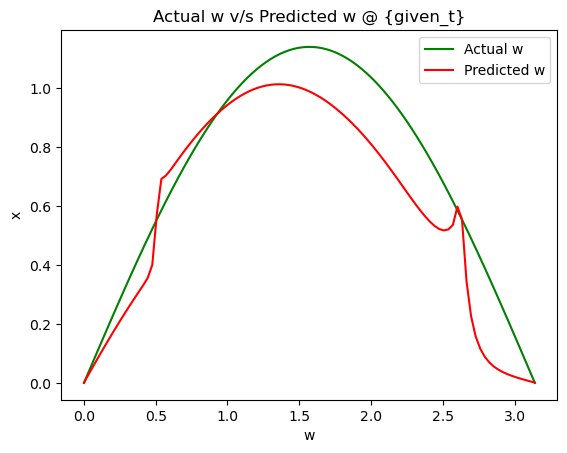

In [16]:
import matplotlib.pyplot as plt

plt.plot(main.x, main.w_exact, color='green', label='Actual w')

plt.plot(main.x, main.w_pred, color='red', label='Predicted w')

plt.title("Actual w v/s Predicted w @ {given_t}")
plt.xlabel("w")
plt.ylabel("x")
plt.legend()

plt.show()

C:\Users\ankit\AppData\Local\Temp\ipykernel_24616\2120511283.py:44: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


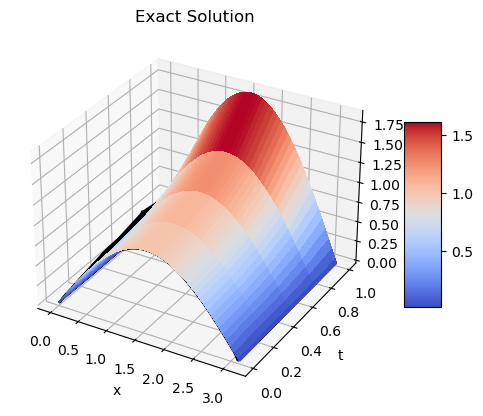

In [63]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

xx = np.linspace(0, np.pi, 100)
tt = np.linspace(0, 1, 5)

arr = []
for i in range(5):
    for j in range(100):
        arr.append([xx[j], tt[i]])

arr = np.array(arr)

output = model.predict(arr)
o_pred = output[:, 0]
w_pred = output[:, 1]

def func_o(x):
    return ( (tf.sin(x[:, 0:1])/tf.cos(x[:, 1:2])))

def func_w(x):
    return tf.sin(x[:, 0:1])/tf.cos(x[:, 1:2])

o_exact = tf.reshape(func_o(arr), [-1])
w_exact = tf.reshape(func_w(arr), [-1])

with tf.Session() as sess:
    w_exact_val = sess.run(w_exact)

# Create meshgrid
X, T = np.meshgrid(xx, tt)
W_exact = np.reshape(w_exact_val, X.shape)

# Create meshgrid for o_pred
W_pred = np.reshape(w_pred, X.shape)

# Plot surface
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, T, W_exact, cmap=cm.coolwarm, linewidth=0, antialiased=False)

# Customize axes
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('o')
ax.set_title('Exact Solution')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

# Plot wireframe for predicted solution
ax.plot_wireframe(X, T, W_pred, color='black')

plt.show()

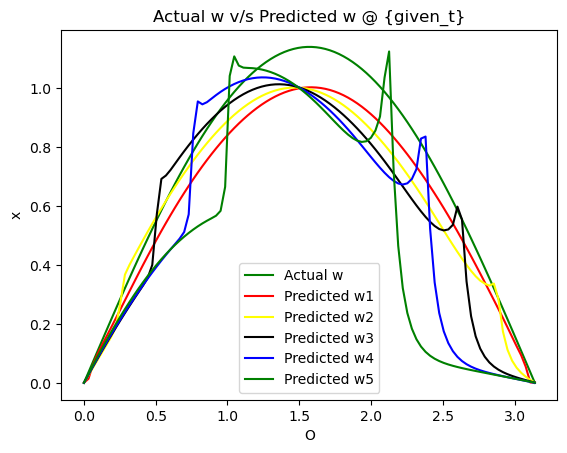

In [17]:
import matplotlib.pyplot as plt

plt.plot(main.x, main.w_exact, color='green', label='Actual w')

plt.plot(main.x, main1.w_pred, color='red', label='Predicted w1')

plt.plot(main.x, main2.w_pred, color='yellow', label='Predicted w2')

plt.plot(main.x, main3.w_pred, color='black', label='Predicted w3')

plt.plot(main.x, main4.w_pred, color='blue', label='Predicted w4')

plt.plot(main.x, main5.w_pred, color='green', label='Predicted w5')

plt.title("Actual w v/s Predicted w @ {given_t}")
plt.xlabel("O")
plt.ylabel("x")
plt.legend()

plt.show()